In [1]:
import sys
import os

# Dynamically add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

In [16]:
#import external libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


from db_config import db
from db_config.db_tables import Matches, Offer



In [ ]:
#this cell compares the matching scores for train and test data to determine the optimal feature selection and amount of clusters

from app import app

with app.app_context():

    # Load the data from the database for all flat providers
    df = pd.read_sql('SELECT * FROM preferences p JOIN flatmate f ON p.user_id = f.id WHERE f.type = TRUE', db.engine)
    #replace NaNs with True to avoid errors

    # Define features and hot-encode categorical variables (optimal feature selection below, values for features should already be hot encoded, this was used to test other features)
    X = pd.get_dummies(df[["semester", "attendance", "fitness"]]) #after interpreting the pair plot below and trying out different combinations, these were the best features
    
    #make sure true and false are replaced with 0 and 1 (safety mechanism)
    X = np.where(X == True, 1, X)
    X = np.where(X == False, 0, X)

    # Split the data into training and testing sets (5 fold cross validation) to see how to model performs on unseen data
    X_train, X_test, df_train, df_test = train_test_split(X, df, test_size=0.2, random_state=42)

    #Standardize features (preprocessing to improve model performance). use minmax scaler to scale the data between 0 and 1 as euclidean distance is used later on
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #since the dataset was created by us, there should be no missing values and no need to impute any of these during preprocessing

    # Define our clusters
    # Define cluster list, start from 2 so that silhouette score can be calculated. stop at 50 because test data doesnt have that many entries
    #iterate over the cluster amount to find the best amount of clusters
    cluster_amount = list(range(2, 50))
    best_score = -1
    best_cluster = None
    for i in cluster_amount:
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=20) #higher n_init to avoid local minima
        # Fit the model
        df_train['cluster'] = kmeans.fit_predict(X_train)
        
        # Check if any cluster is too small
        cluster_sizes = df_train['cluster'].value_counts()
        min_cluster_size = 3  # we want at least 3 matches in each cluster
        if any(cluster_sizes < min_cluster_size):
            continue  # Skip this iteration and try with different number of clusters
        # Evaluate performance using the silhouette score 
        silhouette_avg = silhouette_score(X_train, df_train['cluster'])
        if silhouette_avg > best_score:
            best_train_score = silhouette_avg
            best_train_cluster = i
        

    # Evaluate performance on the test set (same as above)
    for i in cluster_amount:
        kmeans = KMeans(n_clusters=i)
        # Fit the model
        df_test['cluster'] = kmeans.fit_predict(X_test)
        # Check if any cluster is too small
        cluster_sizes = df_test['cluster'].value_counts()
        min_cluster_size = 3  # same as before
        if any(cluster_sizes < min_cluster_size):
            continue  # Skip this iteration and try with different number of clusters
        # Evaluate performance with silhouette score
        silhouette_avg = silhouette_score(X_test, df_test['cluster'])
        if silhouette_avg > best_score:
            best_test_score = silhouette_avg
            best_test_cluster = i

# Best Train Silhouette Score is: 0.5271466158497286 for 43 clusters
# Best Test Silhouette Score is: 0.3214966124172896 for 10 clusters
#this indicates fairly ok clustering but it should be much higher:
#features could not naturally form spherical clusters, which is the assumption of KMeans.
#the chosen number of cluster is limited by the dataset size.
#the features might not be independent and identically distributed, which is another assumption of KMeans.
#we will select 10 clusters for our clustering function, as we want to be able to generalize to new data better and this is the optimal test score. 
# Below we get ConvergenceWarnings but we can ignore these. These occur, because there are many first names, that have the same name, the same semester,
#the same attendence, and the same fitness but are NOT the same person, they are just very similar. In the whole df they have some differences, which are
#not relevant for our matching-algorithm.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (40) found smaller than n_clusters (41). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (40) found smaller than n_clusters (42). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (40) found smaller than n_clusters (43). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (40) found small

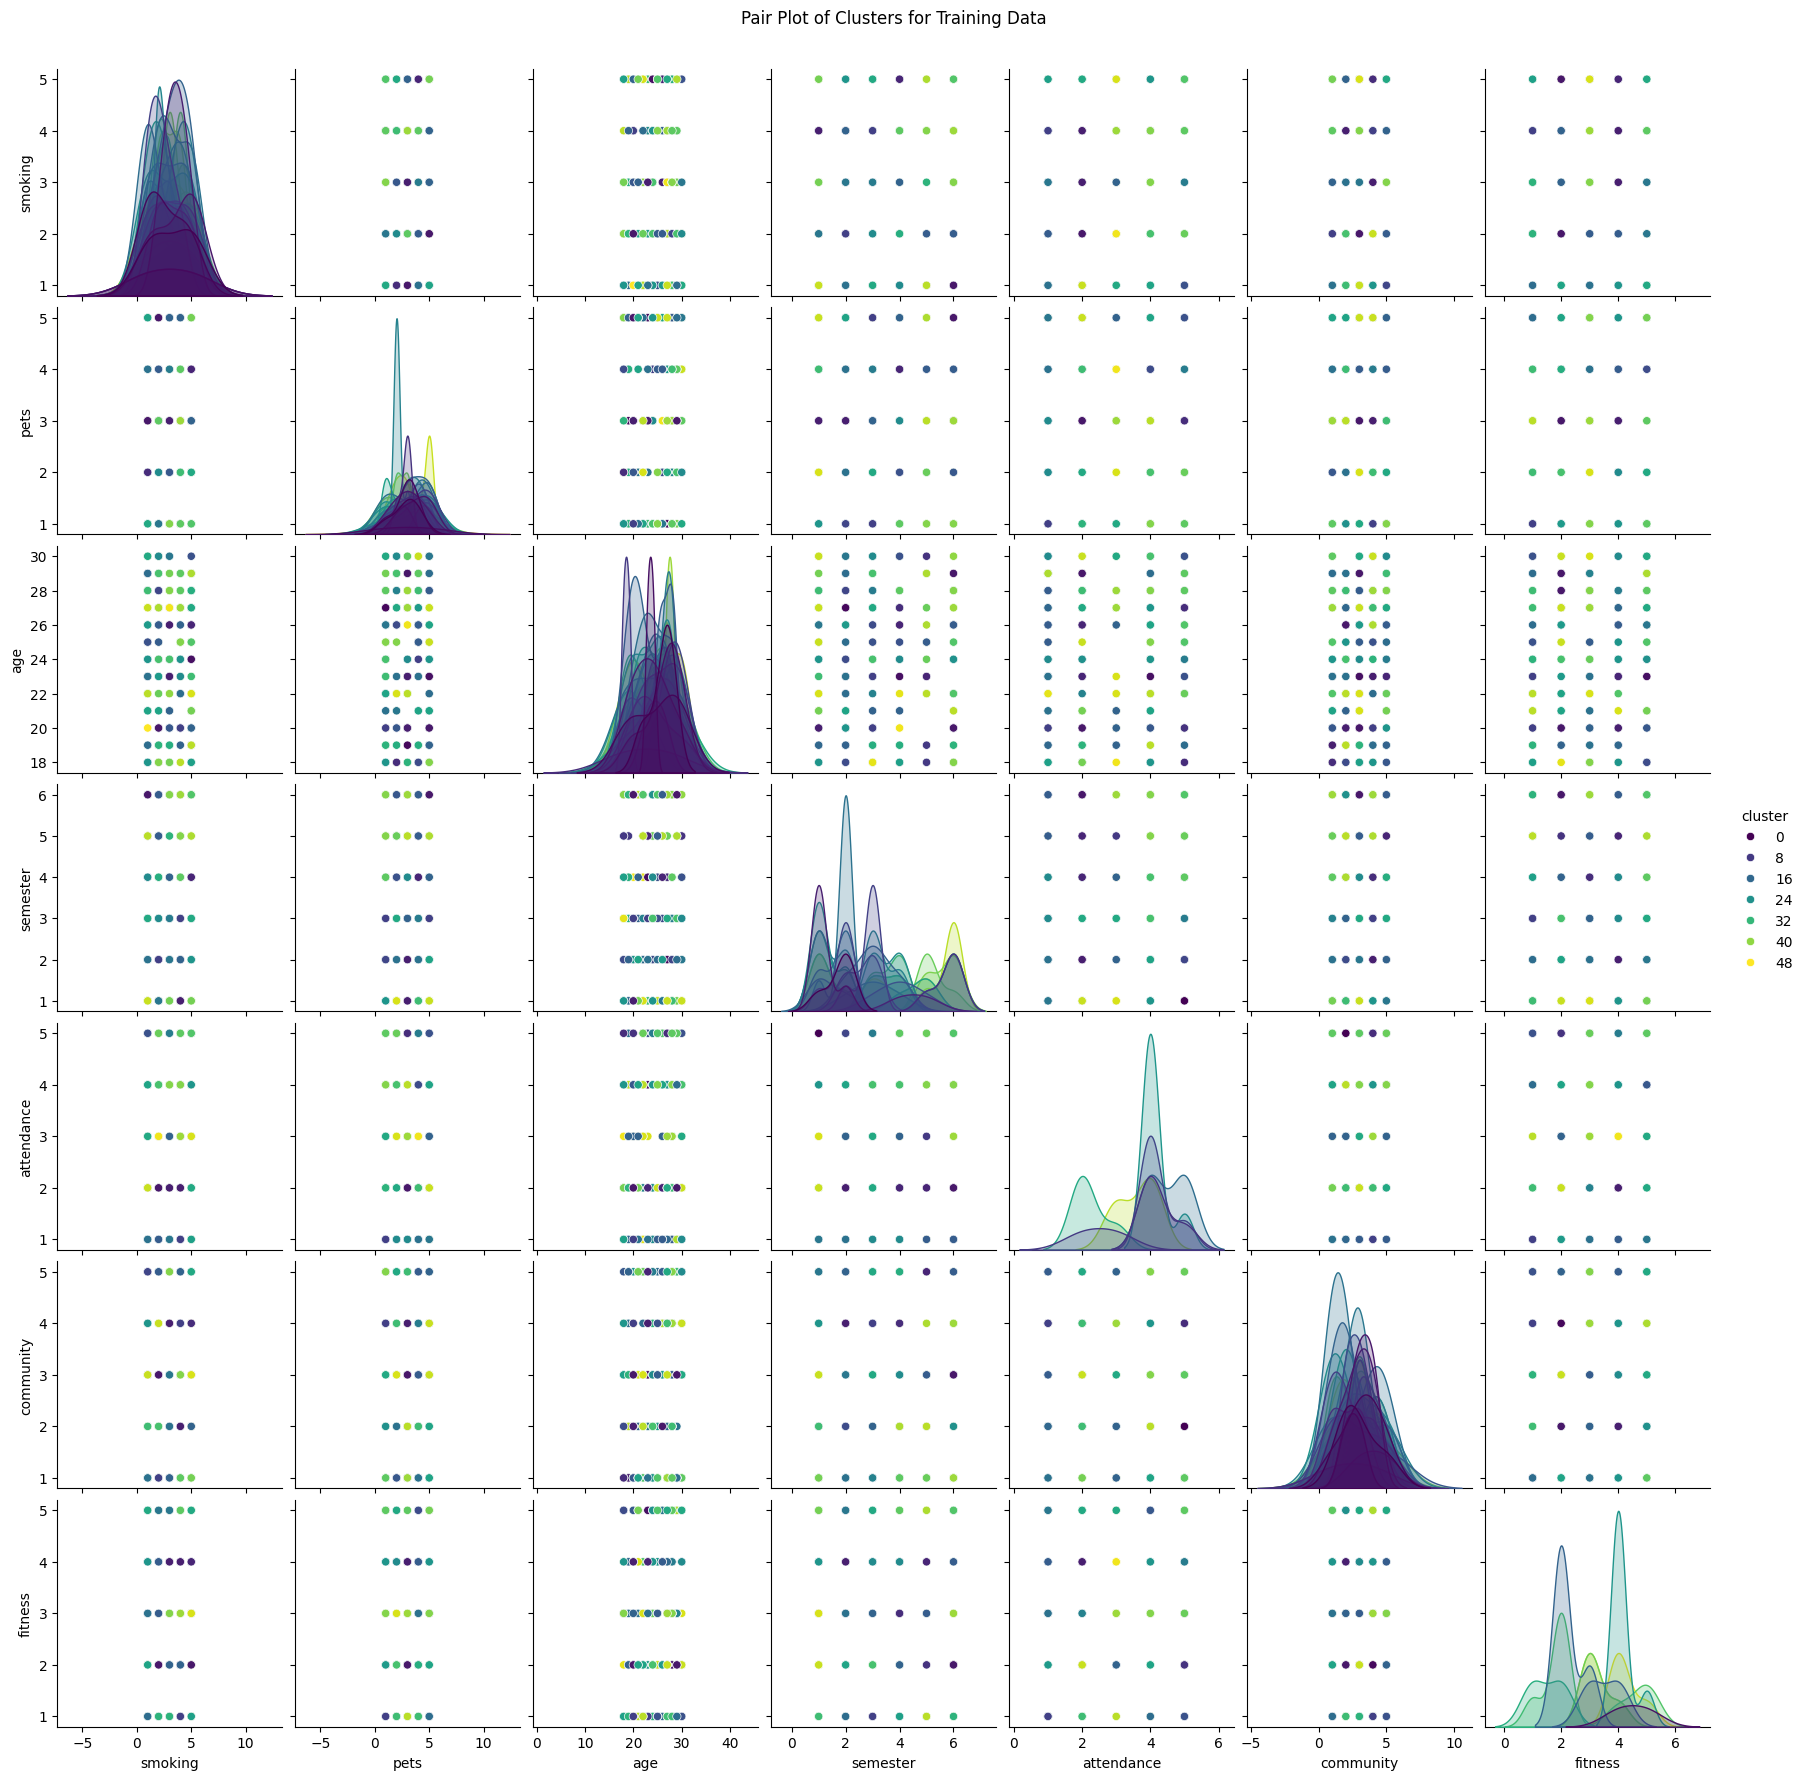

In [32]:
import seaborn as sns

# Create a DataFrame with the training data and cluster labels
df_train_clustered = df_train.copy()
df_train_clustered['cluster'] = df_train['cluster']

# Select features for visualization
features_to_plot = ["smoking", "pets", "age", "semester", "attendance", "community", "fitness"]

# Create a pair plot with the selected features and color by cluster
sns.pairplot(df_train_clustered, vars=features_to_plot, hue='cluster', palette='viridis')
plt.suptitle('Pair Plot of Clusters for Training Data', y=1.02)
plt.show()

#Interpretation of the pair plot:
# semester: Strong separation in both diagonal and scatter plots, particularly with features like attendance and age.
# attendance: Clusters align well with this feature, particularly when combined with semester.
# age: Shows separation when paired with semester or attendance.
# fitness: Moderate separation in scatter plots, particularly with features like attendance.
# Features to exclude:
# smoking: No clear separation across clusters.
# pets: Heavy overlap in all scatter plots and diagonal distributions.
# community: Limited Separation compared To stronger features like attendance.


